# Reminder to startup the Unity render binary if it is not already running!

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

class RRT_Node:
    def __init__(self, pos):
        self.pos = pos
        self.edges = np.array([])

class RRT_Graph:
    def __init__(self, nodes=np.array([])):
        self.nodes = nodes
    def add_node(self, node):
        self.nodes = np.append(self.nodes, node)
    def add_edge(self, node1, node2):
        node1.edges = np.append(node1.edges, node2)
        node2.edges = np.append(node2.edges, node1)
        
    def nearest_node(self, v):
        dist = None
        nearest = None
        for node in self.nodes:
            node_dist = np.linalg.norm(v - node.pos)
            if dist is None or node_dist < dist:
                dist = node_dist
                nearest = node
        return nearest

    # Dijkstra
    def shortest_path_parents(self, source):
        visited = {}
        dist = {}
        parent = {}
        for n in self.nodes:
            visited[n] = False
            parent[n] = None
            dist[n] = [sys.maxsize]
        
        dist[source] = 0
        queue = [source]
        while queue:
            curr = queue.pop(0)
            for n in curr.edges:
                if not visited[n]:
                    queue.append(n)
                    new_dist = dist[curr] + np.linalg.norm(curr.pos - n.pos)
                    if dist[n] > new_dist:
                        parent[n] = curr
                        dist[n] = new_dist
            visited[curr] = True
            
        # helper, assumes the parent exists

        return parent
    
    # goes up the parent chain up to source
    def get_path(self, parent, curr, path):
        if parent[curr]:
            path = self.get_path(parent, parent[curr], path)
        path = np.append(path, curr)
        return path

In [2]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

# not necessary FOR NOW. Function DOES NOT WORK.
def willCollide(p1, p2):
    line_dir = p2 - p1
    
    a = np.dot(line_dir, line_dir)

    for obstacle in self.obstacles:
        center = np.array([obstacle[0], obstacle[1]])
        radius = obstacle[2]
        
        center_p1_dir = p1 - center
        b = 2 * np.dot(line_dir, center_p1_dir)
        c = np.dot(center_p1_dir, center_p1_dir) - radius * radius

        discrim = b * b - 4 * a * c
        if discrim < 0: # no intersection
            continue
        t1 = (-b + np.sqrt(discrim)) / (2 * a);
        t2 = (-b - np.sqrt(discrim)) / (2 * a);

        if (t1 >= 0 and t1 <= 1) or (t2 >= 0 and t2 <= 1):
            return True

    return False

[  0.   0. -30.]
[  0.83347857  -0.55255179 -30.        ]
[  1.10964409  -1.51366188 -30.        ]
[  1.95131697  -2.05364961 -30.        ]
[  1.63808776  -3.00332717 -30.        ]
[  2.24879753  -3.79518169 -30.        ]
[  2.66663234  -4.70370471 -30.        ]
[  3.12000555  -5.59502549 -30.        ]
[  4.04829169  -5.96689219 -30.        ]
[  4.60885301  -5.13877928 -30.        ]
[  5.49717004  -4.67954855 -30.        ]
[  6.46043711  -4.41100331 -30.        ]
[  6.85070029  -5.33170666 -30.        ]
[  7.30235062  -6.2239017  -30.        ]
[  8.08641049  -6.8445869  -30.        ]
[  8.464888    -7.77019738 -30.        ]
[  9.42392571  -8.05347582 -30.        ]
[  9.24449539  -9.03724651 -30.        ]
[  9.  -9. -30.]


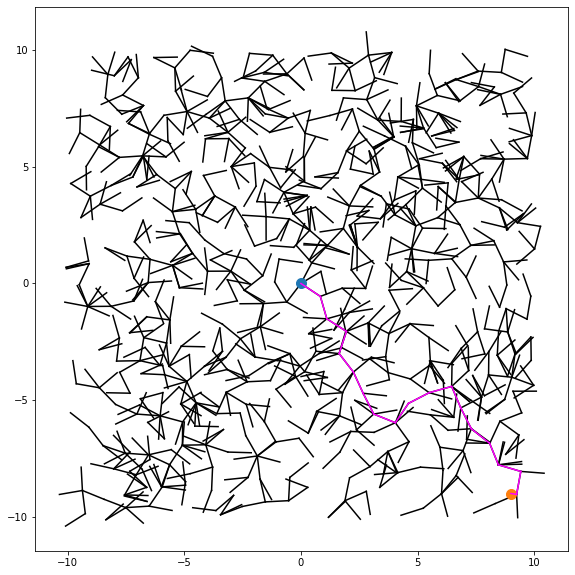

In [3]:
DELTA = 1

bound_start = np.array([-10, -10, -30])
bound_end = np.array([10, 10, -30])

start_pos = np.array([0, 0., -30.])
start_att = np.array([0.,0.,-np.pi/2])

end_pos = start_pos + np.array([9, -9., 0.])
end_att = start_att + np.array([0., 0., 0.])
end_pose = np.append(end_pos, end_att[2])

start_node = RRT_Node(start_pos)

# ONLY PUTTING IN THE START NODE
graph = RRT_Graph(np.array([start_node]))

tree = plt.figure()
plt.gca().set_aspect('equal')
tree.set_size_inches(10, 10)

trials = 1000
for _ in range(trials):
    rand_pos = bound_start + (bound_end - bound_start) * [np.random.random_sample(),
                                                          np.random.random_sample(),
                                                          np.random.random_sample()]
    nearest_node = graph.nearest_node(rand_pos)
    # if collide - for now assume empty environment no collision
    
    # can make it distance delta for more uniformity
    dir_norm = normalize(rand_pos - nearest_node.pos)
    new_node = RRT_Node(nearest_node.pos + DELTA * dir_norm)
    graph.add_node(new_node)
    graph.add_edge(nearest_node, new_node)
    
    xx, yy = [nearest_node.pos[0], new_node.pos[0]], [nearest_node.pos[1], new_node.pos[1]]
    plt.plot(xx, yy, 'k-', figure = tree)

parent = graph.shortest_path_parents(start_node)
nearest_node = graph.nearest_node(end_pos)

path = graph.get_path(parent, nearest_node, np.array([]))

plt.plot(start_node.pos[0], start_node.pos[1], marker='.', markersize=20)
plt.plot(end_pose[0], end_pose[1], '.', markersize=20)

path = np.append(path, RRT_Node(end_pose[:3]))

prev_node = start_node
for node in path:
    xx, yy = [prev_node.pos[0], node.pos[0]], [prev_node.pos[1], node.pos[1]]
    plt.plot(xx, yy, color='fuchsia', figure = tree)
    prev_node = node
    print(node.pos)

In [9]:
# There is some kind of positive relation btwn AMBITION and EPSILON;
# the more ambitious, the greater the need for leeway. 
AMBITION = 2.
EPSILON = 1.

# string = "with half-width {}, center at {}, num_waypoints {}, epsilon {:.2}, & AMBITION {:.2}...".format(
#     half_width, center, num_waypoints, EPSILON, AMBITION)

# big question: how do i set theta for these?
# can do arctan2 + np.pi/2 for eahc
theta = 0

theta_perpen = theta + np.pi / 2
# waypoint_coords = np.vstack((center[0] + (half_width * np.cos(theta)) / (1 + np.sin(theta) * np.sin(theta)), #x
#                              center[1] + (half_width * np.sin(theta) * np.cos(theta)) / (1 + np.sin(theta) * np.sin(theta)), #y
#                              center[2] * np.ones(num_waypoints), #z
#                              theta_perpen))

In [10]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 

from IPython.display import HTML, display
sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    # drone flips over when going too fast ? ? ? SimSpeed adjustment needed??
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = start_pos,
                          attitude_euler_angle=np.array([0., 0., 0.]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    fol_accumulator = None
    pos_accumulator = np.array([curr_pos])
    per_accumulator = None
    
    rand_accumulator = None
    
    curr_waypoint = start_pos
    
    time_counter = 0
    crash = False
    for waypoint_node in path:
        # waypoint = np.append(waypoint_node.pos, np.arctan2(waypoint_node.pos[1], waypoint_node.pos[0]) + np.pi / 2) 
        waypoint = waypoint_node.pos
        
        prev_waypoint = curr_waypoint
        curr_waypoint = waypoint
        
        if (np.array_equal(curr_waypoint[:3], end_pose[:3])):
            target_pose = curr_waypoint
            EPSILON = 0.1
                
        while np.linalg.norm(curr_pos - curr_waypoint[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            # clean solution from: https://stackoverflow.com/questions/31273991/
            d = curr_waypoint[:3] - prev_waypoint[:3]
            t = -np.dot(prev_waypoint[:3] - curr_pos, d) / np.linalg.norm(d)**2
            # 2d only for now
            curr_pos_perpend = prev_waypoint[:3] + (d)*t
            
            if not (np.array_equal(curr_waypoint[:3], end_pose[:3])):
                target_pose = (curr_pos_perpend + normalize(curr_waypoint[:3] - curr_pos_perpend) * AMBITION)
                # curr_att considers x=0 as pi/2
                att_to_target = np.arctan2(target_pose[1] - curr_pos[1],
                                           target_pose[0] - curr_pos[0])
                
                # HOW TO CHANGE THIS?
                target_pose = np.append(target_pose, att_to_target) # attitude
                
                rand_accumulator = np.append(rand_accumulator, target_pose[3])
                
                if fol_accumulator is None:
                    fol_accumulator = np.array([target_pose])
                else:
                    fol_accumulator = np.vstack((fol_accumulator, target_pose))

            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=target_pose,
                                            duration=0.01)
    
    
            if per_accumulator is None:
                per_accumulator = np.array([curr_pos_perpend])
            else:
                per_accumulator = np.vstack((per_accumulator, curr_pos_perpend))
    
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
    
#     f = open("observation notes continuous point lemniscate.txt", "a")
#     if not crash:
#         f.write(string + " it took {:.2f} sec\n".format(time_counter))
#     else:
#         f.write(string + " it crashed :(\n")
#     f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
        
    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=200)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()











Final pose [  8.96  -9.05 -29.93   0.  ]


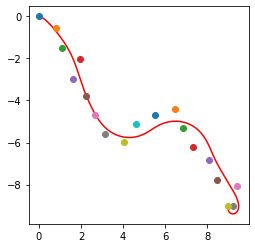

In [11]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

plt.gca().set_aspect('equal', adjustable='box')
# plt.plot(fol_accumulator.T[0], fol_accumulator.T[1], '.')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1], 'r')
# plt.plot(per_accumulator.T[0], per_accumulator.T[1], 'g')
for waypoint_node in path:
    plt.plot(waypoint_node.pos[0], waypoint_node.pos[1], 'o')